In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torch.optim as optim

In [2]:
device = torch.device('cpu')

In [3]:
device

device(type='cpu')

In [4]:
#tensorboard 
tbwriter = SummaryWriter()

In [5]:
dataset = datasets.ImageFolder("./data/caltech101/101_ObjectCategories/", transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((227,227))
    ]))  
        # input size should be : (b x 3 x 227 x 227)
        # The image in the original paper states that width and height are 224 pixels, but
        # the dimensions after first convolution layer do not lead to 55 x 55.

train, test = torch.utils.data.random_split(dataset,[7000,2144])


train_ds = torch.utils.data.DataLoader(train, batch_size=4,
                                          shuffle=True)



In [6]:
classes = []
labels = dataset.class_to_idx
for i in labels:
    classes.append(i) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BACKGROUND_Google BACKGROUND_Google chandelier grand_piano


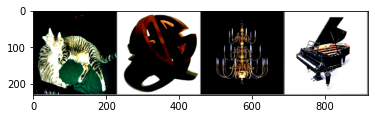

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_ds)
images, label = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[label[j]] for j in range(4)))


In [8]:
torch.autograd.set_detect_anomaly(True)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels=96, kernel_size = (11,11), stride= 4) #(b, 96, 55, 55)
        self.norm = nn.LocalResponseNorm(5, k=2, alpha=0.00004, beta=0.75) #k = 2, n = 5, α = 10−4, and β = 0.75.
        self.pool = nn.MaxPool2d(3,2) #(b, 96, 27, 27)
        self.dropout = nn.Dropout2d(0.5)
        self.conv2 = nn.Conv2d(96, 256, 5)  #(b, 256, 23, 23)
        self.conv3 = nn.Conv2d(256, 384, 3) 
        self.conv4 = nn.Conv2d(384, 384, 3)  
        self.conv5 = nn.Conv2d(384, 256, 3) 
        self.fc1 = nn.Linear(256 * 2 * 2, 4096) 
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,102)

    def forward(self,x):
        x = self.pool(self.norm(F.relu(self.conv1(x)))) #(b, 96, 55, 55) after max pooling #(b, 96, 27, 27)
        x = self.pool(self.norm(F.relu(self.conv2(x)))) #(b, 256, 23, 23) after max pooling #(b, 256, 11, 11)

        x = F.relu(self.conv3(x)) # (b, 384, 9, 9)

        x = F.relu(self.conv4(x)) # (b, 384, 7, 7)

        x = self.pool(F.relu(self.conv5(x))) #(b, 256, 2, 2)

        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) 
        return x
    

net = Net().to(device)

In [9]:
initial_lr = 0.01
momentum = 0.9
weight_decay = 0.0005

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [ ]:
num_epochs = 10
total_steps = 1
for epoch in range(num_epochs):
    num =+ 1
    print(num)
    running_loss = 0
    lr_scheduler.step()
    for i, data in enumerate(train_ds, 0):
        img, label = data
       # print(img.shape, label.shape)
        
        img, label = img.to(device), label.to(device)
        
        #calculate loss
        output = net(img)
        #output = model(img)
        #print(output.shape)
        loss = loss_function(output,label)
        
        # update parameters
        optimizer.zero_grad() # zeres the gradient
        loss.backward() #calculates the gradient
        optimizer.step()
        
        #running_loss += loss.item()
        
        
        if total_steps % 10 == 0:
            with torch.no_grad():
                _, preds = torch.max(output, 1)
                accuracy = torch.sum(preds == label)

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                    .format(epoch + 1, total_steps, loss.item(), accuracy.item()))
                tbwriter.add_scalar('loss', loss.item(), total_steps)
                tbwriter.add_scalar('accuracy', accuracy.item(), total_steps)

            # print out gradient values and parameter average values
        if total_steps % 100 == 0:
            with torch.no_grad():
                # print and save the grad of the parameters
                # also print and save parameter values
                print('*' * 10)
                for name, parameter in net.named_parameters():
                    if parameter.grad is not None:
                        avg_grad = torch.mean(parameter.grad)
                        print('\t{} - grad_avg: {}'.format(name, avg_grad))
                        tbwriter.add_scalar('grad_avg/{}'.format(name), avg_grad.item(), total_steps)
                        tbwriter.add_histogram('grad/{}'.format(name),
                                parameter.grad.cpu().numpy(), total_steps)
                    if parameter.data is not None:
                        avg_weight = torch.mean(parameter.data)
                        print('\t{} - param_avg: {}'.format(name, avg_weight))
                        tbwriter.add_histogram('weight/{}'.format(name),
                                parameter.data.cpu().numpy(), total_steps)
                        tbwriter.add_scalar('weight_avg/{}'.format(name), avg_weight.item(), total_steps)

        total_steps += 1

        
        


print('Finished Training')
        
        
        

/Users/tomiwa/miniforge3/envs/pytorch_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/Users/tomiwa/miniforge3/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension,

1
Epoch: 1 	Step: 10 	Loss: 4.6205 	Acc: 1
Epoch: 1 	Step: 20 	Loss: 4.6033 	Acc: 2
Epoch: 1 	Step: 30 	Loss: 4.6184 	Acc: 0
Epoch: 1 	Step: 40 	Loss: 4.6182 	Acc: 0
Epoch: 1 	Step: 50 	Loss: 4.6229 	Acc: 0
Epoch: 1 	Step: 60 	Loss: 4.6001 	Acc: 0
Epoch: 1 	Step: 70 	Loss: 4.5651 	Acc: 0
Epoch: 1 	Step: 80 	Loss: 4.6035 	Acc: 0
Epoch: 1 	Step: 90 	Loss: 4.6284 	Acc: 0
Epoch: 1 	Step: 100 	Loss: 4.5727 	Acc: 0
**********
	conv1.weight - grad_avg: 9.268453595723258e-07
	conv1.weight - param_avg: 0.00013130746083334088
	conv1.bias - grad_avg: -7.666447345400229e-06
	conv1.bias - param_avg: -0.0029982689302414656
	conv2.weight - grad_avg: -1.1076602277171332e-05
	conv2.weight - param_avg: -5.0281241783523e-06
	conv2.bias - grad_avg: -3.1818297429708764e-05
	conv2.bias - param_avg: 0.0001689816126599908
	conv3.weight - grad_avg: -1.3007642337470315e-05
	conv3.weight - param_avg: -7.019167696853401e-06
	conv3.bias - grad_avg: -0.00010346659837523475
	conv3.bias - param_avg: -6.53210227028466

	conv3.bias - param_avg: 0.0007194372010417283
	conv4.weight - grad_avg: -0.0007291976362466812
	conv4.weight - param_avg: 5.7635214034235105e-05
	conv4.bias - grad_avg: -0.005724161863327026
	conv4.bias - param_avg: 0.001264869119040668
	conv5.weight - grad_avg: -0.0008807261474430561
	conv5.weight - param_avg: 8.172128582373261e-05
	conv5.bias - grad_avg: -0.006081124301999807
	conv5.bias - param_avg: 0.0024958213325589895
	fc1.weight - grad_avg: -0.00015941431047394872
	fc1.weight - param_avg: 3.9827382352086715e-06
	fc1.bias - grad_avg: -0.0007638942915946245
	fc1.bias - param_avg: -7.863512291805819e-05
	fc2.weight - grad_avg: -0.00011393581371521577
	fc2.weight - param_avg: 9.041766134032514e-06
	fc2.bias - grad_avg: -0.0011491215554997325
	fc2.bias - param_avg: 0.0007120020454749465
	fc3.weight - grad_avg: 4.565306813142378e-11
	fc3.weight - param_avg: -1.1539430488483049e-05
	fc3.bias - grad_avg: -5.843592831844546e-10
	fc3.bias - param_avg: -0.0014833653112873435
Epoch: 1 	Ste

	fc1.bias - grad_avg: -0.0005251085385680199
	fc1.bias - param_avg: 0.0001367091026622802
	fc2.weight - grad_avg: -3.119848406640813e-05
	fc2.weight - param_avg: 8.607008567196317e-06
	fc2.bias - grad_avg: -0.0007058149203658104
	fc2.bias - param_avg: 0.0010536820627748966
	fc3.weight - grad_avg: 3.5381128582478993e-11
	fc3.weight - param_avg: -1.1539421393536031e-05
	fc3.bias - grad_avg: 7.304491039805683e-11
	fc3.bias - param_avg: -0.0014833657769486308
Epoch: 1 	Step: 910 	Loss: 3.5592 	Acc: 0
Epoch: 1 	Step: 920 	Loss: 4.8718 	Acc: 0
Epoch: 1 	Step: 930 	Loss: 3.6381 	Acc: 0
Epoch: 1 	Step: 940 	Loss: 3.8667 	Acc: 0
Epoch: 1 	Step: 950 	Loss: 2.9990 	Acc: 1
Epoch: 1 	Step: 960 	Loss: 4.0212 	Acc: 0
Epoch: 1 	Step: 970 	Loss: 4.3578 	Acc: 0
Epoch: 1 	Step: 980 	Loss: 4.4299 	Acc: 1
Epoch: 1 	Step: 990 	Loss: 4.5341 	Acc: 0
Epoch: 1 	Step: 1000 	Loss: 3.9184 	Acc: 1
**********
	conv1.weight - grad_avg: 0.0006267240387387574
	conv1.weight - param_avg: 0.0001458566839573905
	conv1.bias

Epoch: 1 	Step: 1310 	Loss: 3.8277 	Acc: 1
Epoch: 1 	Step: 1320 	Loss: 2.9868 	Acc: 1
Epoch: 1 	Step: 1330 	Loss: 4.8722 	Acc: 0
Epoch: 1 	Step: 1340 	Loss: 4.6951 	Acc: 0
Epoch: 1 	Step: 1350 	Loss: 3.0704 	Acc: 1
Epoch: 1 	Step: 1360 	Loss: 4.1238 	Acc: 0
Epoch: 1 	Step: 1370 	Loss: 3.5475 	Acc: 0
Epoch: 1 	Step: 1380 	Loss: 4.8288 	Acc: 0
Epoch: 1 	Step: 1390 	Loss: 4.6167 	Acc: 0
Epoch: 1 	Step: 1400 	Loss: 3.4615 	Acc: 1
**********
	conv1.weight - grad_avg: -0.001337205059826374
	conv1.weight - param_avg: 0.00029017514316365123
	conv1.bias - grad_avg: -0.0028824033215641975
	conv1.bias - param_avg: -0.003212718293070793
	conv2.weight - grad_avg: -0.0017158311093226075
	conv2.weight - param_avg: -6.250267324503511e-05
	conv2.bias - grad_avg: -0.003912415821105242
	conv2.bias - param_avg: 0.0010269384365528822
	conv3.weight - grad_avg: -0.0008607961935922503
	conv3.weight - param_avg: 2.2513722797157243e-05
	conv3.bias - grad_avg: -0.006664801388978958
	conv3.bias - param_avg: 0.002

	conv3.bias - grad_avg: -0.0032537977676838636
	conv3.bias - param_avg: 0.0023225389886647463
	conv4.weight - grad_avg: -0.0005493396311067045
	conv4.weight - param_avg: 3.6847541196038947e-05
	conv4.bias - grad_avg: -0.002866000635549426
	conv4.bias - param_avg: 0.003876739414408803
	conv5.weight - grad_avg: -0.0004992691101506352
	conv5.weight - param_avg: 7.757964340271428e-05
	conv5.bias - grad_avg: -0.0023083642590790987
	conv5.bias - param_avg: 0.006314883008599281
	fc1.weight - grad_avg: -8.814169268589467e-05
	fc1.weight - param_avg: 5.2235341172490735e-06
	fc1.bias - grad_avg: -0.0002924764412455261
	fc1.bias - param_avg: 0.0004959904472343624
	fc2.weight - grad_avg: -4.41635784227401e-05
	fc2.weight - param_avg: 1.5617424651281908e-05
	fc2.bias - grad_avg: -0.00028139696223661304
	fc2.bias - param_avg: 0.0016161991516128182
	fc3.weight - grad_avg: -1.3695920265954786e-11
	fc3.weight - param_avg: -1.15393540909281e-05
	fc3.bias - grad_avg: -4.3826944851055316e-10
	fc3.bias - p

	fc1.weight - param_avg: 1.925440301420167e-06
	fc1.bias - grad_avg: 0.0008816203335300088
	fc1.bias - param_avg: 0.0004974519251845777
	fc2.weight - grad_avg: 9.288910950999707e-05
	fc2.weight - param_avg: 1.5999647075659595e-05
	fc2.bias - grad_avg: 0.0009837428806349635
	fc2.bias - param_avg: 0.001717163948342204
	fc3.weight - grad_avg: 9.130613799757104e-12
	fc3.weight - param_avg: -1.153932862507645e-05
	fc3.bias - grad_avg: -4.3826944851055316e-10
	fc3.bias - param_avg: -0.001483371714130044
Epoch: 2 	Step: 2210 	Loss: 3.0410 	Acc: 2
Epoch: 2 	Step: 2220 	Loss: 3.5313 	Acc: 1
Epoch: 2 	Step: 2230 	Loss: 3.6993 	Acc: 1
